In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import scale
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep
#datadir = '/'.join(cwd.split('/')) + '/Twitter-Bot-DSGA1001/data/'

def loadSentimentData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, index_col=0)
    data.dropna(inplace=True)

#     for each_col in data.columns:
#         if each_col.find('_mv') > 0:
#             data[each_col] = scale(data[each_col])
        
    data.drop(['arousal_mv','valence_mv','label'], 1, inplace=True)
    data.index = data.index.astype('int64')
    return data

def loadUserData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, encoding="cp1252")
    data = data[['id','favourites_count','followers_count','friends_count','listed_count','statuses_count', 'label', 'default_profile', 'default_profile_image','verified']]
    data.set_index('id', inplace=True)
#     data = data.apply(lambda x: scale(x) if x.name != 'label' else x)
    return data


sentiment = loadSentimentData('sentiment_dist_varol_dump.csv')
account = loadUserData('varol-2017-users.csv')
data = account.join(sentiment, how='inner')

# Feature Selection

In [3]:
# Train test split
sample_filt = np.random.uniform(0,1, data.shape[0]) > 0.8

X_train = data[sample_filt].drop('label',1)
Y_train = data[sample_filt].label
X_test = data[~sample_filt].drop('label',1)
Y_test = data[~sample_filt].label

In [4]:
# DecisionTree for MI scores
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

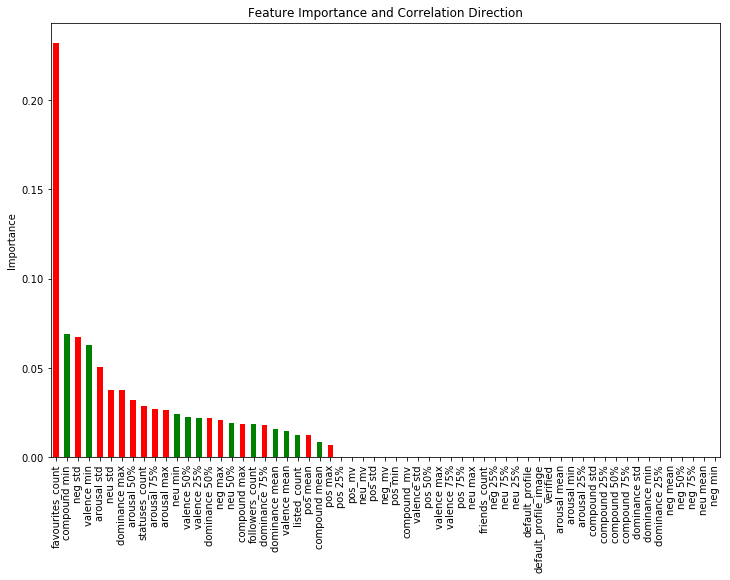

In [5]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [6]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

In [7]:
# Baseline Logistic Regression and SVM
lr = LogisticRegression(C=1e30)
svm = SVC(kernel="linear")

svm_pipeline = Pipeline(steps = [('normalize', Normalizer()),
                                 ('estimator', svm)])

kfold = KFold(10, True)
lr_cv = cross_val_score(lr, X_train_filt, Y_train, cv = kfold, scoring="roc_auc")
svm_cv = cross_val_score(svm_pipeline, X_train_filt, Y_train, cv = kfold, scoring="roc_auc")

In [8]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

print("\nSVM Mean CV AUC Score: {:0.3}".format(np.mean(svm_cv))+
      "\nSVM StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(svm_cv)/len(svm_cv))))

LR Mean CV AUC Score: 0.779
LR StdErr CV AUC Score: 0.0188

SVM Mean CV AUC Score: 0.724
SVM StdErr CV AUC Score: 0.0352


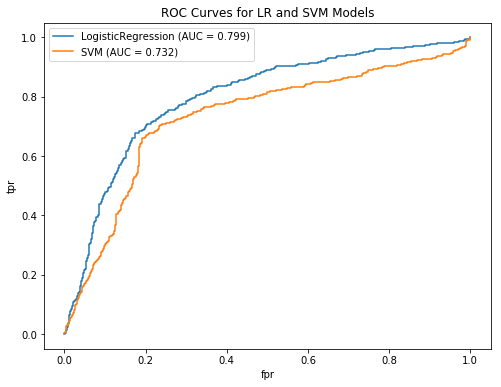

In [10]:
# ROC Curve for single train/test split baseline model
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm], ["LogisticRegression", "SVM"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Pipelines

In [32]:
lr_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('top_k', SelectFromModel(DecisionTreeClassifier(criterion='entropy'))),
                        ('estimator', LogisticRegression())])

svm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('top_k', SelectFromModel(DecisionTreeClassifier(criterion='entropy'))),
                        ('normalize', Normalizer()),
                        ('estimator', SVC())])

gbm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('top_k', SelectFromModel(DecisionTreeClassifier(criterion='entropy'))),
                        ('estimator', GradientBoostingClassifier())])

# Grid Search

In [51]:
lr_param_grid = {'top_k__threshold': ['mean','1.25*mean','0.75*mean','median'],
                 'estimator__C': [10**x for x in range(-8,3)]}

svm_param_grid = {'top_k__threshold': ['mean','1.25*mean','0.75*mean','median'],
                  'estimator__C': [10**x for x in range(-8,3)],
                  'estimator__kernel': ['linear','poly','rbf','sigmoid'],
                  'estimator__degree': [2,3,4]}

gbm_param_grid = {'top_k__threshold': ['mean','1.25*mean','0.75*mean','median'],
                  'estimator__learning_rate': [10**x for x in range(-8,0)],
                  'estimator__max_depth': [5,25,50],
                  'estimator__min_samples_leaf': [5,25,50,100,250,500],
                  'estimator__subsample': [0.5,0.75,1]}

In [20]:
lr_grid_search = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=10, scoring='roc_auc')
lr_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('variance_thresh', VarianceThreshold(threshold=0.0)), ('top_k', SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            m...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'top_k__threshold': ['mean', '1.25*mean', '0.75*mean', 'median'], 'estimator__C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
svm_grid_search = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=10, scoring='roc_auc')
svm_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('variance_thresh', VarianceThreshold(threshold=0.0)), ('top_k', SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            m...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'top_k__threshold': ['mean', '1.25*mean', '0.75*mean', 'median'], 'estimator__C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'estimator__degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [52]:
gbm_grid_search = GridSearchCV(gbm_pipeline, param_grid=gbm_param_grid, cv=10, scoring='roc_auc')
gbm_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('variance_thresh', VarianceThreshold(threshold=0.0)), ('top_k', SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            m...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'top_k__threshold': ['mean', '1.25*mean', '0.75*mean', 'median'], 'estimator__learning_rate': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'estimator__max_depth': [5, 25, 50], 'estimator__min_samples_leaf': [5, 25, 50, 100, 250, 500], 'estimator__subsample': [0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [54]:
gbm_grid_search.best_params_

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 25,
 'estimator__min_samples_leaf': 50,
 'estimator__subsample': 1,
 'top_k__threshold': '1.25*mean'}

In [53]:
gbm_grid_search.best_score_

0.8580450579231067